In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random
import pandas as pd
from tqdm import tqdm

file_path = r'C:\Users\n10766316\OneDrive - Queensland University of Technology\VRES\script files\burgers_numerical\burgers_numerical.csv'
df = pd.read_csv(file_path)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT*2) # 2x the outputs for imaginary part 
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        a, b = x.chunk(2, dim=-1)
        return a + 1j*b

torch.manual_seed(42)
model = FCN(2,1,100,5)

pbar_exists = False
# This is for the progress bar because sometimes
# I'm running the script again without
# restarting the kernel

# Initial and boundary conditions

The domain of the problem is

$x\in[-5,5]$ and $t\in[0,\pi/2]$

The differential equation is 

$ih_t+0.5h_{xx}+|h|^2h=0$

$i$ is the imaginary unit and $h$ is the wavefunction.

The initial conditions are given as 

$h(x,0) = 2 \text{sech}(x)$

$h(-5,t)=h(5,t)$

$h_x(-5,t)=h_x(5,t)$

In [2]:
def f_initial(x):
    return 2/torch.cosh(x)

# For initial condition loss
x_initial = torch.linspace(-5,5,100).view(-1,1)
t_initial = torch.zeros_like(x_initial)
xt_initial = torch.cat((x_initial, t_initial), dim=1)
h_initial = f_initial(x_initial)

# For boundary loss
t_boundary = torch.linspace(0,np.pi/2,100).view(-1,1).requires_grad_(True)
x_boundary = torch.full_like(t_boundary, 5.0, requires_grad=True)
x_boundary_negative = torch.full_like(t_boundary, -5.0, requires_grad=True)

xt_boundary = torch.cat((x_boundary, t_boundary), dim=1)
xt_boundary_negative = torch.cat((x_boundary_negative, t_boundary), dim=1)
# If you look at the boundary conditions, it requires a 5 and -5 in x
# Need to calculate boundary term and its derivative in the loop

# Physics informed points
seed = 42
random.seed(seed)
n = 10000
x_random = [random.uniform(-5, 5) for _ in range(n)]
t_random = [random.uniform(0, np.pi/2) for _ in range(n)]

x = torch.tensor(x_random).view(-1,1).requires_grad_(True)
t = torch.tensor(t_random).view(-1,1).requires_grad_(True)

xt = torch.cat((x, t), dim=1)
#xt_symm = torch.cat((-1*x, t), dim=1)
#plt.plot(xt.detach().numpy()[:,0], xt.detach().numpy()[:,1], 'k.')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 1500

loss_history = [[],[]] # Epoch, loss
pbar = tqdm(total=n_epochs, desc="Initializing")

for i in range(n_epochs):
    optimizer.zero_grad()
    
    # Initial condition loss
    loss_i = torch.mean((h_initial - (model(xt_initial)).real) ** 2)
    loss_i += torch.mean((model(xt_initial).imag) ** 2)

    # Boundary condition loss. hbn and hb are h boundary negative and h boundary
    hbn = model(xt_boundary_negative)
    hb = model(xt_boundary)
    loss_b = torch.mean( abs((hbn - hb)**2) )

    # next boundary cond. is that the derivatives of these need to be equal
    # I'm just gonna call h_x(-5,t) and h_x(5,t) h_xn and h_x, respectively
    hb_xn = torch.autograd.grad(hbn, x_boundary_negative, torch.ones_like(hbn), create_graph=True)[0]
    hb_x = torch.autograd.grad(hb, x_boundary, torch.ones_like(hb), create_graph=True)[0]
    loss_b += torch.mean( abs((hb_xn - hb_x)**2) )

    # Physics-informed loss
    
    h = model(xt)
    h_x = torch.autograd.grad(h, x, torch.ones_like(h), create_graph=True)[0]
    h_xx = torch.autograd.grad(h_x, x, torch.ones_like(h_x), create_graph=True)[0]
    h_t = torch.autograd.grad(h, t, torch.ones_like(h), create_graph=True)[0]
    loss_physics = torch.mean( abs((1j*h_t + 0.5*h_xx + abs(h)**2*h)**2) )

    # Backpropagate joint loss
    loss = loss_i + loss_b + loss_physics
    loss.backward(retain_graph=True)
    optimizer.step()

    
    loss_history[0].append(loss.detach().numpy())
    loss_history[1].append(i)
    pbar.set_description(f'Epoch {i + 1}/{n_epochs}, Loss IC: {loss_i.item():.8f}, Loss BC: {loss_b.item():.8f}, Loss Phys: {loss_physics.item():.8f}')
    
    #pbar.set_description(f'Epoch {i + 1}/{n_epochs}, Loss IC: {loss_i.item():.8f}, Loss BC: {loss_b.item():.8f}, Loss Phys: {loss_physics.item():.8f}, Loss Stat.: {stat_loss.item():.8f}')
    pbar.update(1)
pbar.close()

Epoch 1500/1500, Loss IC: 0.09114588, Loss BC: 0.00005700, Loss Phys: 0.07082134: 100%|██████████| 1500/1500 [05:34<00:00,  4.49it/s]


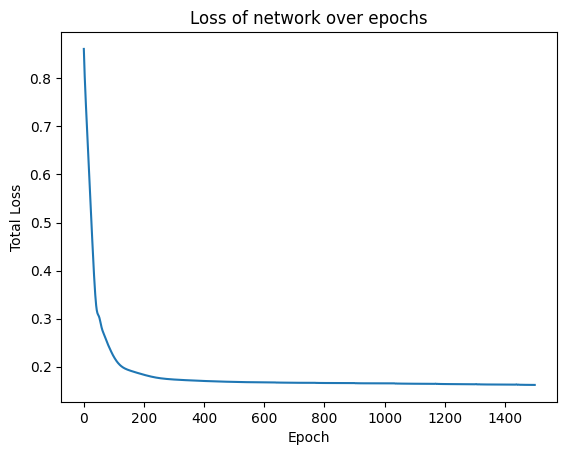

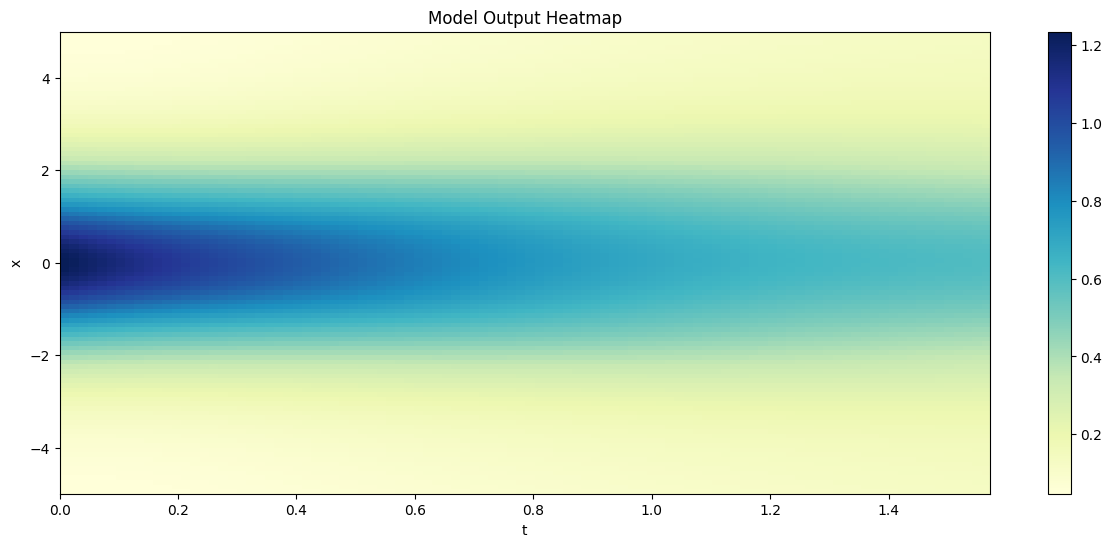

In [3]:
plt.figure()
plt.plot(loss_history[1], loss_history[0])
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss of network over epochs')

x = np.linspace(-5, 5, 100)
t = np.linspace(0, np.pi/2, 100)
X, T = np.meshgrid(x, t)
grid = np.vstack((X.ravel(), T.ravel())).T

grid_tensor = torch.tensor(grid, dtype=torch.float32)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = abs(model(grid_tensor).numpy())

# Reshape and transpose the output for plotting as a heatmap
outputs_2d = outputs.reshape(X.shape).T  # Transpose the matrix

# Plotting as a heatmap
plt.figure(figsize=(15, 6))
plt.imshow(outputs_2d, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', cmap='YlGnBu', aspect='auto')
plt.colorbar()  # Add a color bar which maps values to colors

plt.xlabel('t')
plt.ylabel('x')
plt.title('Model Output Heatmap')
plt.show()

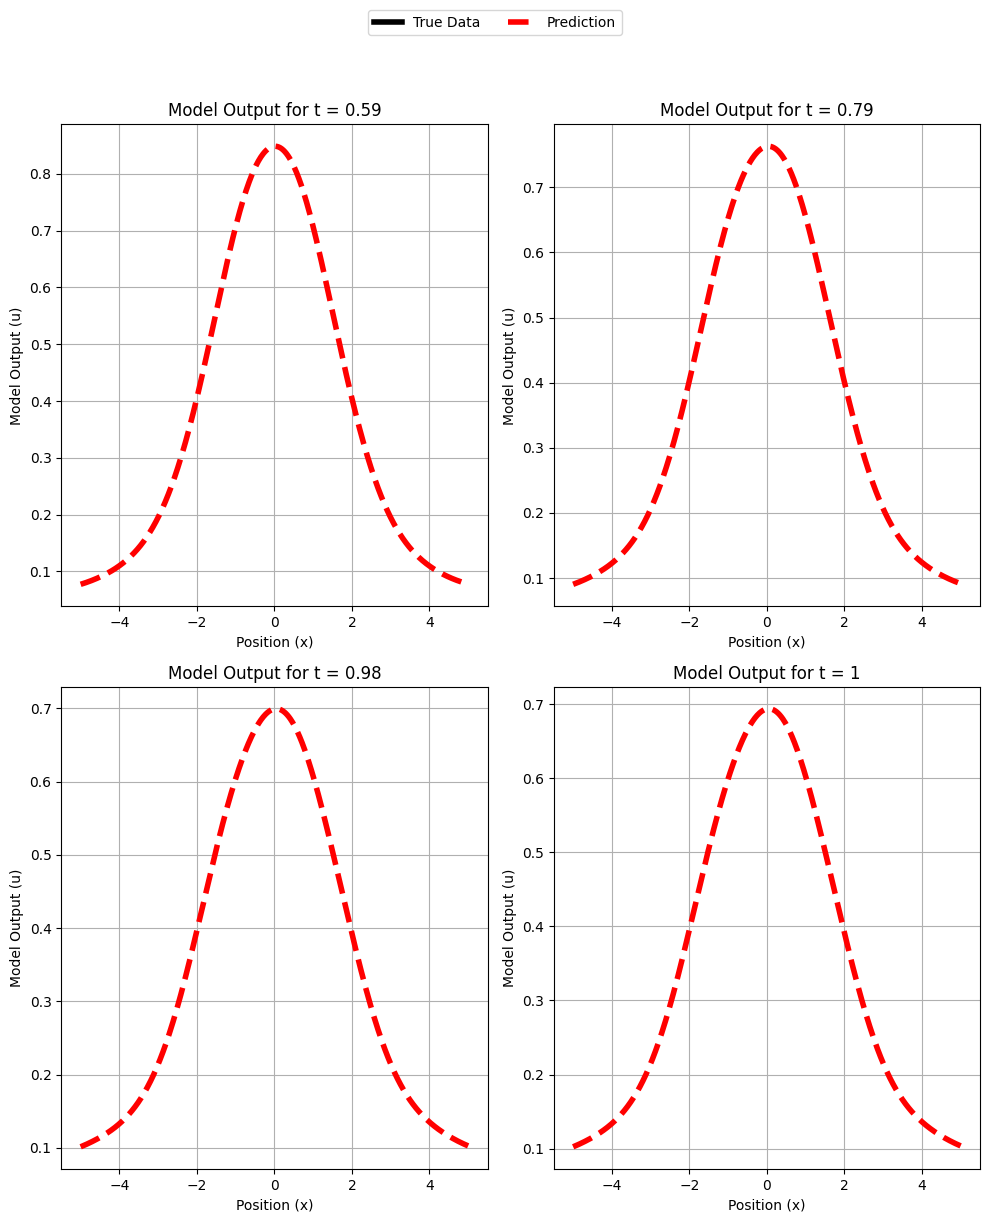

In [4]:
x = torch.linspace(-5, 5, 500)
time_values = [0.59, 0.79, 0.98, 1]
plt.figure(figsize=(10, 12))

# Need an x_vector for the numerical data because I didn't bring it over from matlab
n_numerical = len(df.iloc[:,1])
x_numerical = np.linspace(-1,1,n_numerical)

# plotting parameters
lw = 4

for i, constant_t in enumerate(time_values, 1):
    numerical_data = df.iloc[:, i-1]

    xt = torch.column_stack((x, torch.full_like(x, constant_t)))

    with torch.no_grad():
        u = abs(model(xt))

    plt.subplot(2, 2, i)
    # plt.plot(x_numerical, numerical_data, 'k', linewidth=lw)
    plt.plot(x.numpy(), u.numpy(), 'r--', linewidth=lw)
    plt.xlabel('Position (x)')
    plt.ylabel('Model Output (u)')
    plt.title(f'Model Output for t = {constant_t}')
    plt.grid(True)

# Create custom lines for the legend
true_line = mlines.Line2D([], [], color='black', linewidth=lw, label='True Data')
prediction_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=lw, label='Prediction')

# Place the legend outside the subplots
plt.figlegend(handles=[true_line, prediction_line], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to make room for the legend
plt.show()

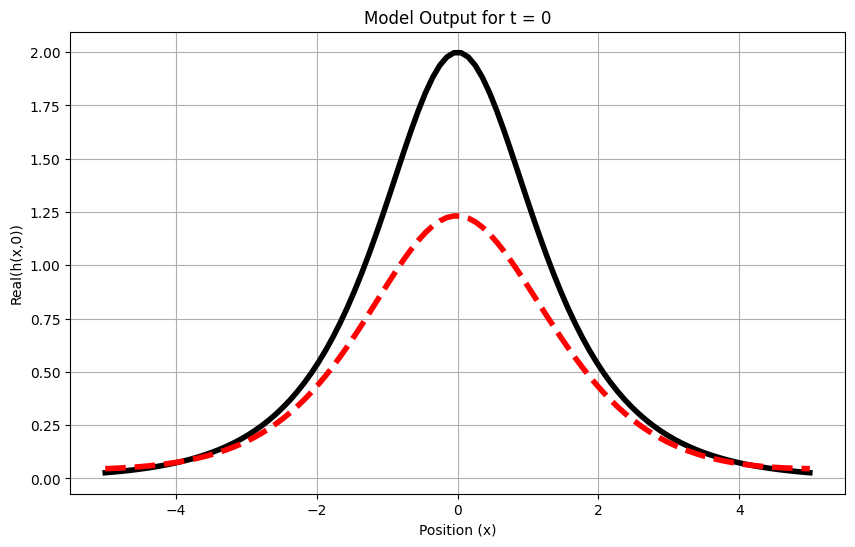

In [5]:
x = torch.linspace(-5, 5, 100)  

constant_t = 0 

xt = torch.column_stack((x, torch.full_like(x, constant_t)))

with torch.no_grad():
    u = model(xt).real

plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), 2/torch.cosh(x), 'k', linewidth=lw)
plt.plot(x.numpy(), u.numpy(), 'r--', linewidth=lw)
plt.xlabel('Position (x)')
plt.ylabel('Real(h(x,0))')
plt.title(f'Model Output for t = {constant_t}')
plt.grid(True)
plt.show()

In [6]:
x_test = torch.tensor([-.02,.02]).view(-1,1)
t_test = torch.tensor([1,1]).view(-1,1)
xt_test = torch.cat((x_test, t_test), dim=1)

model(xt_test)

print('max = ' + str(max(u.numpy())) + ', ' + 'min = ' + str(min(u.numpy())))

max = [1.231774], min = [0.04588537]


In [7]:
# Convert the notebook to a script
# from functions import notebook_to_script
# notebook_to_script('schrodinger_pinn.ipynb', 'schrodinger_pinn.py')